In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns
from pathlib import Path

%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import  BatchNormalization
from tensorflow.keras import layers, models

In [3]:
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [4]:
tumor_image_dir = r'C:\Users\DELL\Desktop\python project\Deep Learning\Tumor Detection\brain_tumor_dataset'

In [5]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

In [6]:
def convert_path_to_df(tumor_image_dir):
    image_dir = Path(tumor_image_dir)
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.PNG'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(tumor_image_dir)

In [7]:
image_df

,Filepath,Label
0,C:\Users\DELL\Desktop\python project\Deep Lear...,no
1,C:\Users\DELL\Desktop\python project\Deep Lear...,no
2,C:\Users\DELL\Desktop\python project\Deep Lear...,no
3,C:\Users\DELL\Desktop\python project\Deep Lear...,no
4,C:\Users\DELL\Desktop\python project\Deep Lear...,no
...,...,...
493,C:\Users\DELL\Desktop\python project\Deep Lear...,no
494,C:\Users\DELL\Desktop\python project\Deep Lear...,no
495,C:\Users\DELL\Desktop\python project\Deep Lear...,no
496,C:\Users\DELL\Desktop\python project\Deep Lear...,no


In [8]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(tumor_image_dir).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

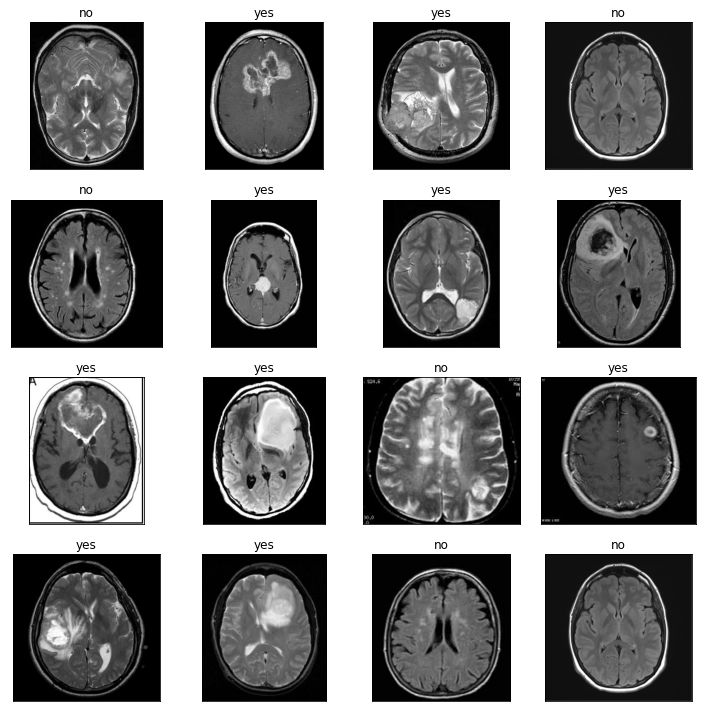

In [9]:
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [10]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [11]:
train_generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.xception.preprocess_input,
    validation_split = 0.2
)
test_generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.xception.preprocess_input
)

In [12]:
train_image = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = IMAGE_SIZE,
    batvh_size = BATCH_SIZE,
    shuffle = True,
    color_mode = 'rgb',
    class_mode = 'categorical',
    random_seed = 42,
    subset = 'training'
)


Found 319 validated image filenames belonging to 2 classes.


In [13]:
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 79 validated image filenames belonging to 2 classes.


In [14]:
test_image = test_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    shuffle = True,
    color_mode = 'rgb',
    random_seed = 42,
    class_mode = 'categorical'
)

Found 100 validated image filenames belonging to 2 classes.


In [15]:
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

In [16]:
pretrained_model = tf.keras.applications.xception.Xception(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

In [17]:
checkpoint_path = "brain_tumor_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [18]:
early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 5,
                               restore_best_weights = True)

In [19]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-10)

In [20]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)

In [21]:
outputs = Dense(2, activation='softmax')(x)

In [22]:
model = Model(inputs = inputs, outputs = outputs)

In [23]:
from tensorflow.keras.optimizers import Adam

In [24]:
model.compile(
    optimizer=Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [25]:
from tensorflow.keras.callbacks import TensorBoard
import datetime

def create_tensorboard_callback(log_dir, experiment_name):
    log_dir = log_dir + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

In [26]:
history = model.fit(
    train_image,
    steps_per_epoch=len(train_image),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "brain_tumor_classification"),
        checkpoint_callback,
        reduce_lr
    ]
)

Saving TensorBoard log files to: training_logs/brain_tumor_classification/20230511-154902
Epoch 1/100
10/10 [==============================] - 203s 16s/step - loss: 0.8937 - accuracy: 0.6677 - val_loss: 2.4260 - val_accuracy: 0.4304 - lr: 0.0010
Epoch 2/100
10/10 [==============================] - 152s 15s/step - loss: 0.4781 - accuracy: 0.8056 - val_loss: 2.5361 - val_accuracy: 0.4304 - lr: 0.0010
Epoch 3/100
10/10 [==============================] - 147s 15s/step - loss: 0.3091 - accuracy: 0.8715 - val_loss: 2.7625 - val_accuracy: 0.4304 - lr: 0.0010
Epoch 4/100
10/10 [==============================] - 150s 15s/step - loss: 0.2791 - accuracy: 0.8934 - val_loss: 3.3406 - val_accuracy: 0.4304 - lr: 0.0010
Epoch 5/100
10/10 [==============================] - 143s 15s/step - loss: 0.2567 - accuracy: 0.9091 - val_loss: 2.8650 - val_accuracy: 0.4304 - lr: 2.0000e-04
Epoch 6/100
10/10 [==============================] - 150s 15s/step - loss: 0.1633 - accuracy: 0.9436 - val_loss: 2.2956 - val_

In [28]:
results = model.evaluate(test_image, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.07917
Test Accuracy: 97.00%


In [29]:
model.save('model_Xception.h5')

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

<Figure size 432x288 with 0 Axes>

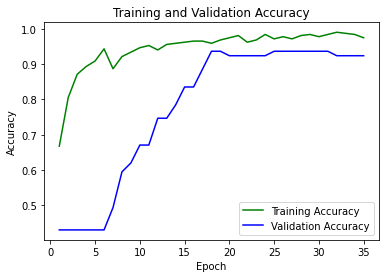

<Figure size 432x288 with 0 Axes>

In [31]:
#accuracy
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()

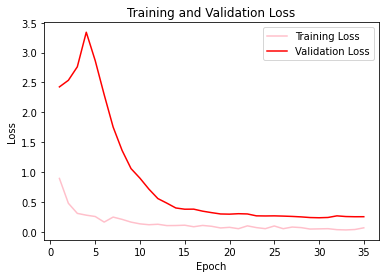

In [32]:
# Loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

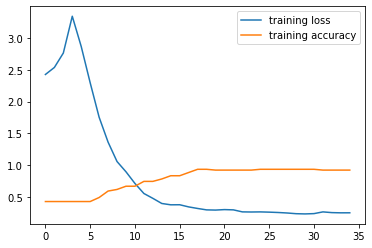

In [34]:
#visualizing the validation loo and validation accuracy graph

plt.plot(history.history['val_loss'], label = 'training loss')
plt.plot(history.history['val_accuracy'], label = 'training accuracy')
plt.legend()

In [36]:
pred = model.predict(test_image)
pred = np.argmax(pred,axis=1)

4/4 [==============================] - 24s 4s/step


In [38]:
labels = (train_image.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [39]:
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['no', 'yes', 'no', 'yes', 'yes']


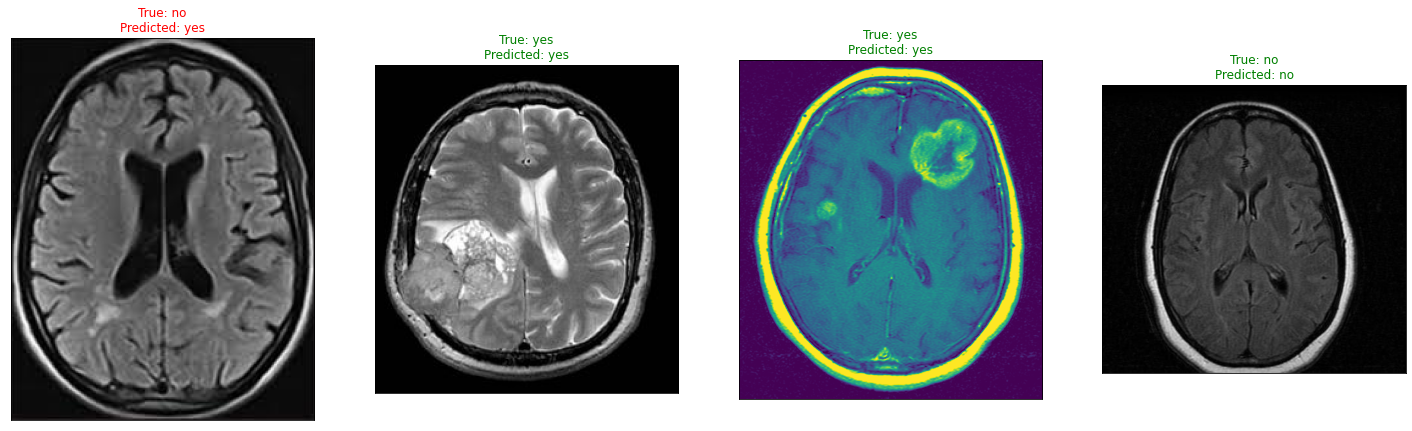

<Figure size 432x288 with 0 Axes>

In [44]:
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()